In [1]:
import os
import gc
import random
import glob
import sys
import random
import scipy.ndimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
from itertools import chain
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.applications.inception_v3 import InceptionV3
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

/home/aumkar/anaconda3/envs/daenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
SOURCE_DIR = os.path.abspath('/data/aumkar/train')
TARGET_DIR = os.path.abspath('/data/aumkar/validation')
DATA_LOAD_DIR = os.path.abspath('/data/aumkar/data_load')

In [4]:
source_path = list(paths.list_images(SOURCE_DIR))
target_path = list(paths.list_images(TARGET_DIR))

labels_source = [p.split(os.path.sep)[-2] for p in source_path]
labels_target = [p.split(os.path.sep)[-2] for p in target_path]

In [5]:
classes = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 'skateboard', 
           'train', 'truck']

In [6]:
def paths_(label, path):
    
    return np.array([x for x in path if '%s' %label in x])

In [7]:
def data_count(x):
    
    xid, xcount = np.unique(x, return_counts=True)
    
    return xid, xcount

In [8]:
def data_balance(label):
    
    id_, count = data_count(label)
    min_count = min(count)
    min_id = np.argmin(id_)
    label_min = label[min_id]
    
    return min_count, label_min

In [9]:
source_data = data_balance(labels_source)
target_data = data_balance(labels_target)

In [10]:
source_data

(7365, 'knife')

In [11]:
target_data

(2075, 'knife')

In [12]:
source_aeroplane = np.random.choice(paths_('aeroplane', source_path), size = source_data[0])
source_bicycle = np.random.choice(paths_('bicycle', source_path), size = source_data[0])
source_bus = np.random.choice(paths_('bus', source_path), size = source_data[0])
source_car = np.random.choice(paths_('car', source_path), size = source_data[0])
source_horse = np.random.choice(paths_('horse', source_path), size = source_data[0])
source_knife = paths_('knife', source_path)
source_motorcycle = np.random.choice(paths_('motorcycle', source_path), size = source_data[0])
source_person = np.random.choice(paths_('person', source_path), size = source_data[0])
source_plant = np.random.choice(paths_('plant', source_path), size = source_data[0])
source_skateboard = np.random.choice(paths_('skateboard', source_path), size = source_data[0])
source_train = np.random.choice(paths_('train', source_path), size = source_data[0])
source_truck = np.random.choice(paths_('truck', source_path), size = source_data[0])

In [13]:
source_path_ = list(chain(source_aeroplane, source_bicycle, source_bus, source_car, source_horse, source_knife, 
                     source_motorcycle, source_person, source_plant, source_skateboard, source_train, source_truck))

In [14]:
target_aeroplane = np.random.choice(paths_('aeroplane', target_path), size = target_data[0])
target_bicycle = np.random.choice(paths_('bicycle', target_path), size = target_data[0])
target_bus = np.random.choice(paths_('bus', target_path), size = target_data[0])
target_car = np.random.choice(paths_('car', target_path), size = target_data[0])
target_horse = np.random.choice(paths_('horse', target_path), size = target_data[0])
target_knife = paths_('knife', target_path)
target_motorcycle = np.random.choice(paths_('motorcycle', target_path), size = target_data[0])
target_person = np.random.choice(paths_('person', target_path), size = target_data[0])
target_plant = np.random.choice(paths_('plant', target_path), size = target_data[0])
target_skateboard = np.random.choice(paths_('skateboard', target_path), size = target_data[0])
target_train = np.random.choice(paths_('train', target_path), size = target_data[0])
target_truck = np.random.choice(paths_('truck', target_path), size = target_data[0])

In [15]:
target_path_ = list(chain(target_aeroplane, target_bicycle, target_bus, target_car, target_horse, target_knife, 
                     target_motorcycle, target_person, target_plant, target_skateboard, target_train, target_truck))

In [16]:
source_y = [p.split(os.path.sep)[-2] for p in source_path_]
target_y = [p.split(os.path.sep)[-2] for p in target_path_]

In [17]:
le = LabelEncoder()
labels = le.fit_transform(source_y)
labels_t = le.fit_transform(target_y)

In [18]:
len(source_path_)

95255

In [19]:
labels.shape

(95255,)

In [20]:
labels_unique = np.load(os.path.join(DATA_LOAD_DIR, 'labels.npy'))

In [21]:
clf = linear_model.SGDClassifier(max_iter = 1000, tol = 1e-4, n_jobs = -1, loss = 'log')

In [22]:
def model_create(transfer_model):
    if transfer_model == 'InceptionV3':
        with tf.device('/gpu:1'):
            return InceptionV3(weights = 'imagenet', include_top = False)
    elif transfer_model == 'VGG16':
        with tf.device('/gpu:1'):
            return VGG16(weights = 'imagenet', include_top = False)
    elif transfer_model == 'VGG19':
        with tf.device('/gpu:1'):
            return VGG19(weights = 'imagenet', include_top = False)
    elif transfer_model == 'Xception':
        with tf.device('/gpu:1'):
            return Xception(weights = 'imagenet', include_top = False)
    elif transfer_model == 'DenseNet121':
        with tf.device('/gpu:1'):
            return DenseNet121(weights = 'imagenet', include_top = False)

In [23]:
def model_reshape(transfer_model, features):
    if transfer_model == 'InceptionV3':
        return features.reshape((features.shape[0], 5 * 5 * 2048))
    elif transfer_model == 'VGG16':
        return features.reshape((features.shape[0], 7 * 7 * 512))
    elif transfer_model == 'VGG19':
        return features.reshape((features.shape[0], 7 * 7 * 512))
    elif transfer_model == 'Xception':
        return features.reshape((features.shape[0], 7 * 7 * 2048))
    elif transfer_model == 'DenseNet121':
        return features.reshape((features.shape[0], 7 * 7 * 1024))

In [24]:
def model_train(i, model, features, label):
    
    print('Training batch: ', i + 1)
    model.partial_fit(features, label, classes = labels_unique)
       
    return model

In [25]:
def target_pred(model, target_features):
    
    print('Predicting batch features')
    return model.predict(target_features)

In [26]:
def feature_extract(tpath, spath, batch_size, pseudo_labels, source_labels, model_, source, trained_model, iteration, n_k):
    
    pred = []
    s_path = []
    
    #if iteration == 1:
    model1 = model_create(model_)
    
    if source == 'target' and iteration != 0:
        
        '''batch_aeroplane = target_aeroplane[batch * val: (batch + 1) * val]
        batch_bicycle = target_bicycle[batch * val: (batch + 1) * val]
        batch_bus = target_bus[batch * val: (batch + 1) * val]
        batch_car = target_car[batch * val: (batch + 1) * val]
        batch_horse = target_horse[batch * val: (batch + 1) * val]
        batch_knife = target_knife[batch * val: (batch + 1) * val]
        batch_motorcycle = target_motorcycle[batch * val: (batch + 1) * val]
        batch_person = target_person[batch * val: (batch + 1) * val]
        batch_plant = target_plant[batch * val: (batch + 1) * val]
        batch_skateboard = target_skateboard[batch * val: (batch + 1) * val]
        batch_train = target_train[batch * val: (batch + 1) * val]
        batch_truck = target_truck[batch * val: (batch + 1) * val]'''
        
        idx = np.arange(len(tpath))
        np.random.shuffle(idx)
        
        sampled_idxs = idx[:int(n_k)]
        
        target_sample = np.array(tpath)[sampled_idxs]
        labels_sample = pseudo_labels[sampled_idxs]
        
        slabels = source_labels.tolist()
        
        spath = spath + target_sample.tolist()
        slabels = slabels + labels_sample.tolist()
        
        assert(len(spath) == len(slabels))
        
    for (b, i) in enumerate(range(0, len(spath), batch_size)):
        
        print("Processing batch {}/{}".format(b + 1, int(np.ceil(len(spath) / float(batch_size)))))
        
        batchPaths = spath[i: i + batch_size]
        if source == 'target' and iteration != 0:
            batchLabels = np.array(slabels)[i: i + batch_size]
        else:
            batchLabels = source_labels[i: i + batch_size]
        batchImages = []
        
        for imagePath in batchPaths:
            
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)

            image = np.expand_dims(image, axis=0)
            image = imagenet_utils.preprocess_input(image)

            batchImages.append(image)

        batchImages = np.vstack(batchImages)
          
        features = model1.predict(batchImages, batch_size = batch_size)
        features1 = model_reshape(model_, features)

        if source == 'source' and b == 0 and iteration == 0:
            model_partial = model_train(b, clf, features1, batchLabels)
        elif source == 'source' and b != 0 and iteration == 0:
            model_partial = model_train(b, model_partial, features1, batchLabels)
        elif source == 'target' and iteration == 0:
            pred.append(target_pred(trained_model, features1))
        elif source == 'target' and b == 0 and iteration != 0:
            model_partial = model_train(b, clf, features1, batchLabels)
        elif source == 'target' and b != 0 and iteration != 0:
            model_partial = model_train(b, model_partial, features1, batchLabels)

    del spath, features, features1, source_labels, tpath, pseudo_labels, model1, model_
    gc.collect()
    
    if source == 'target' and iteration != 0:
        del slabels, idx, sampled_idxs, target_sample, labels_sample
        gc.collect()
        return model_partial
    if source == 'source' and iteration == 0:
        return model_partial
    elif source == 'target' and iteration == 0:
        return np.hstack(np.asarray(pred))

In [27]:
step_size = 128

val = int(step_size / len(classes))

In [ ]:
def batch_gen(): 
    
    while True:
        
        for batch in range(source_data[0]):
            
            batch_aeroplane = source_aeroplane[batch * val: (batch + 1) * val]
            batch_bicycle = source_bicycle[batch * val: (batch + 1) * val]
            batch_bus = source_bus[batch * val: (batch + 1) * val]
            batch_car = source_car[batch * val: (batch + 1) * val]
            batch_horse = source_horse[batch * val: (batch + 1) * val]
            batch_knife = source_knife[batch * val: (batch + 1) * val]
            batch_motorcycle = source_motorcycle[batch * val: (batch + 1) * val]
            batch_person = source_person[batch * val: (batch + 1) * val]
            batch_plant = source_plant[batch * val: (batch + 1) * val]
            batch_skateboard = source_skateboard[batch * val: (batch + 1) * val]
            batch_train = source_train[batch * val: (batch + 1) * val]
            batch_truck = source_truck[batch * val: (batch + 1) * val]
            
            source_ = list(chain(batch_aeroplane, batch_bicycle, batch_bus, batch_car, batch_horse, batch_knife, 
                                 batch_motorcycle, batch_person, batch_plant, batch_skateboard, batch_train, batch_truck))
            
            aeroy = [p.split(os.path.sep)[-2] for p in source_aeroplane]
            batch_aeroplane_y = aeroy[batch * val: (batch + 1) * val]
            
            biy = [p.split(os.path.sep)[-2] for p in source_bicycle]
            batch_bicycle_y = biy[batch * val: (batch + 1) * val]
            
            busy = [p.split(os.path.sep)[-2] for p in source_bus]
            batch_bus_y = busy[batch * val: (batch + 1) * val]
            
            cary = [p.split(os.path.sep)[-2] for p in source_car]
            batch_car_y = cary[batch * val: (batch + 1) * val]
            
            horsey = [p.split(os.path.sep)[-2] for p in source_horse]
            batch_horse_y = horsey[batch * val: (batch + 1) * val]
            
            knifey = [p.split(os.path.sep)[-2] for p in source_knife]
            batch_knife_y = knifey[batch * val: (batch + 1) * val]
            
            motory = [p.split(os.path.sep)[-2] for p in source_motorcycle]
            batch_motorcycle_y = motory[batch * val: (batch + 1) * val]
            
            pery = [p.split(os.path.sep)[-2] for p in source_person]
            batch_person_y = pery[batch * val: (batch + 1) * val]
            
            planty = [p.split(os.path.sep)[-2] for p in source_plant]
            batch_plant_y = planty[batch * val: (batch + 1) * val]
            
            skatey = [p.split(os.path.sep)[-2] for p in source_skateboard]
            batch_skateboard_y = skatey[batch * val: (batch + 1) * val]
            
            trainy = [p.split(os.path.sep)[-2] for p in source_train]
            batch_train_y = trainy[batch * val: (batch + 1) * val]
            
            trucky = [p.split(os.path.sep)[-2] for p in source_truck]
            batch_truck_y = trucky[batch * val: (batch + 1) * val]
            
            source_lab = list(chain(batch_aeroplane_y, batch_bicycle_y, batch_bus_y, batch_car_y, batch_horse_y, batch_knife_y, 
                                 batch_motorcycle_y, batch_person_y, batch_plant_y, batch_skateboard_y, batch_train_y, 
                                 batch_truck_y))
            
            sourcey = le.fit_transform(source_lab)
            
            

In [28]:
def sslda_online(M):
    
    score = []
    
    svm_model = feature_extract(None, source_path_, step_size, None, labels, 'InceptionV3', 'source', None, 0, None)
    
    target_predictions = feature_extract(None, target_path_, step_size, None, labels_t, 'InceptionV3', 'target', svm_model, 0, None)
    
    print(classification_report(labels_t, target_predictions, target_names = classes))
    
    #source_path_, labels_ = batch_gen()
    
    
    for i in range(1, M):
        
        print('Iteration: ', i)
         
        n = (i / float(M)) * len(target_path)
        
        if i == 1:
            mod = feature_extract(target_path_, source_path_, step_size, target_predictions, labels, 'InceptionV3', 'target', None, i, n)
            fin_pred = feature_extract(None, target_path_, step_size, None, labels_t, 'InceptionV3', 'target', mod, 0, None)
        else:
            mod = feature_extract(target_path_, source_path_, step_size, fin_pred, labels, 'InceptionV3', 'target', None, i, n)
            fin_pred = feature_extract(None, target_path_, step_size, None, labels_t, 'InceptionV3', 'target', mod, 0, None)
        
        score.append(accuracy_score(labels_t, fin_pred))
    
    #tf.reset_default_graph()
    
    del svm_model, target_predictions, mod
    
    return fin_pred, score

In [29]:
pred = []
mean_acc = []

for i in range(20):
    
    print('ENSEMBLE ITERATION: ', i+1)
    
    sslda_pred, acc = sslda_online(3)
    
    pred.append(sslda_pred)
    mean_acc.append(acc)

ENSEMBLE ITERATION:  1
Instructions for updating:
Colocations handled automatically by placer.
Processing batch 1/745
Training batch:  1
Processing batch 2/745
Training batch:  2
Processing batch 3/745
Training batch:  3
Processing batch 4/745
Training batch:  4
Processing batch 5/745
Training batch:  5
Processing batch 6/745
Training batch:  6
Processing batch 7/745
Training batch:  7
Processing batch 8/745
Training batch:  8
Processing batch 9/745
Training batch:  9
Processing batch 10/745
Training batch:  10
Processing batch 11/745
Training batch:  11
Processing batch 12/745
Training batch:  12
Processing batch 13/745
Training batch:  13
Processing batch 14/745
Training batch:  14
Processing batch 15/745
Training batch:  15
Processing batch 16/745
Training batch:  16
Processing batch 17/745
Training batch:  17
Processing batch 18/745
Training batch:  18
Processing batch 19/745
Training batch:  19
Processing batch 20/745
Training batch:  20
Processing batch 21/745
Training batch:  21

Training batch:  176
Processing batch 177/745
Training batch:  177
Processing batch 178/745
Training batch:  178
Processing batch 179/745
Training batch:  179
Processing batch 180/745
Training batch:  180
Processing batch 181/745
Training batch:  181
Processing batch 182/745
Training batch:  182
Processing batch 183/745
Training batch:  183
Processing batch 184/745
Training batch:  184
Processing batch 185/745
Training batch:  185
Processing batch 186/745
Training batch:  186
Processing batch 187/745
Training batch:  187
Processing batch 188/745
Training batch:  188
Processing batch 189/745
Training batch:  189
Processing batch 190/745
Training batch:  190
Processing batch 191/745
Training batch:  191
Processing batch 192/745
Training batch:  192
Processing batch 193/745
Training batch:  193
Processing batch 194/745
Training batch:  194
Processing batch 195/745
Training batch:  195
Processing batch 196/745
Training batch:  196
Processing batch 197/745
Training batch:  197
Processing ba

Training batch:  355
Processing batch 356/745
Training batch:  356
Processing batch 357/745
Training batch:  357
Processing batch 358/745
Training batch:  358
Processing batch 359/745
Training batch:  359
Processing batch 360/745
Training batch:  360
Processing batch 361/745
Training batch:  361
Processing batch 362/745
Training batch:  362
Processing batch 363/745
Training batch:  363
Processing batch 364/745
Training batch:  364
Processing batch 365/745
Training batch:  365
Processing batch 366/745
Training batch:  366
Processing batch 367/745
Training batch:  367
Processing batch 368/745
Training batch:  368
Processing batch 369/745
Training batch:  369
Processing batch 370/745
Training batch:  370
Processing batch 371/745
Training batch:  371
Processing batch 372/745
Training batch:  372
Processing batch 373/745
Training batch:  373
Processing batch 374/745
Training batch:  374
Processing batch 375/745
Training batch:  375
Processing batch 376/745
Training batch:  376
Processing ba

Training batch:  534
Processing batch 535/745
Training batch:  535
Processing batch 536/745
Training batch:  536
Processing batch 537/745
Training batch:  537
Processing batch 538/745
Training batch:  538
Processing batch 539/745
Training batch:  539
Processing batch 540/745
Training batch:  540
Processing batch 541/745
Training batch:  541
Processing batch 542/745
Training batch:  542
Processing batch 543/745
Training batch:  543
Processing batch 544/745
Training batch:  544
Processing batch 545/745
Training batch:  545
Processing batch 546/745
Training batch:  546
Processing batch 547/745
Training batch:  547
Processing batch 548/745
Training batch:  548
Processing batch 549/745
Training batch:  549
Processing batch 550/745
Training batch:  550
Processing batch 551/745
Training batch:  551
Processing batch 552/745
Training batch:  552
Processing batch 553/745
Training batch:  553
Processing batch 554/745
Training batch:  554
Processing batch 555/745
Training batch:  555
Processing ba

Training batch:  713
Processing batch 714/745
Training batch:  714
Processing batch 715/745
Training batch:  715
Processing batch 716/745
Training batch:  716
Processing batch 717/745
Training batch:  717
Processing batch 718/745
Training batch:  718
Processing batch 719/745
Training batch:  719
Processing batch 720/745
Training batch:  720
Processing batch 721/745
Training batch:  721
Processing batch 722/745
Training batch:  722
Processing batch 723/745
Training batch:  723
Processing batch 724/745
Training batch:  724
Processing batch 725/745
Training batch:  725
Processing batch 726/745
Training batch:  726
Processing batch 727/745
Training batch:  727
Processing batch 728/745
Training batch:  728
Processing batch 729/745
Training batch:  729
Processing batch 730/745
Training batch:  730
Processing batch 731/745
Training batch:  731
Processing batch 732/745
Training batch:  732
Processing batch 733/745
Training batch:  733
Processing batch 734/745
Training batch:  734
Processing ba

Predicting batch features
Processing batch 135/195
Predicting batch features
Processing batch 136/195
Predicting batch features
Processing batch 137/195
Predicting batch features
Processing batch 138/195
Predicting batch features
Processing batch 139/195
Predicting batch features
Processing batch 140/195
Predicting batch features
Processing batch 141/195
Predicting batch features
Processing batch 142/195
Predicting batch features
Processing batch 143/195
Predicting batch features
Processing batch 144/195
Predicting batch features
Processing batch 145/195
Predicting batch features
Processing batch 146/195
Predicting batch features
Processing batch 147/195
Predicting batch features
Processing batch 148/195
Predicting batch features
Processing batch 149/195
Predicting batch features
Processing batch 150/195
Predicting batch features
Processing batch 151/195
Predicting batch features
Processing batch 152/195
Predicting batch features
Processing batch 153/195
Predicting batch features
Proce

/home/aumkar/anaconda3/envs/daenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

  aeroplane       0.00      0.00      0.00      2075
    bicycle       0.02      0.00      0.00      2075
        bus       0.00      0.00      0.00      2075
        car       0.11      0.04      0.05      2075
      horse       0.08      0.00      0.00      2075
      knife       0.14      0.00      0.00      2075
 motorcycle       0.27      0.00      0.00      2075
     person       0.00      0.00      0.00      2075
      plant       0.38      0.00      0.00      2075
 skateboard       0.00      0.00      0.00      2075
      train       0.17      0.05      0.08      2075
      truck       0.08      0.94      0.15      2075

avg / total       0.10      0.09      0.02     24900

Iteration:  1
Processing batch 1/889
Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training

Training batch:  167
Processing batch 168/889
Training batch:  168
Processing batch 169/889
Training batch:  169
Processing batch 170/889
Training batch:  170
Processing batch 171/889
Training batch:  171
Processing batch 172/889
Training batch:  172
Processing batch 173/889
Training batch:  173
Processing batch 174/889
Training batch:  174
Processing batch 175/889
Training batch:  175
Processing batch 176/889
Training batch:  176
Processing batch 177/889
Training batch:  177
Processing batch 178/889
Training batch:  178
Processing batch 179/889
Training batch:  179
Processing batch 180/889
Training batch:  180
Processing batch 181/889
Training batch:  181
Processing batch 182/889
Training batch:  182
Processing batch 183/889
Training batch:  183
Processing batch 184/889
Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing ba

Training batch:  346
Processing batch 347/889
Training batch:  347
Processing batch 348/889
Training batch:  348
Processing batch 349/889
Training batch:  349
Processing batch 350/889
Training batch:  350
Processing batch 351/889
Training batch:  351
Processing batch 352/889
Training batch:  352
Processing batch 353/889
Training batch:  353
Processing batch 354/889
Training batch:  354
Processing batch 355/889
Training batch:  355
Processing batch 356/889
Training batch:  356
Processing batch 357/889
Training batch:  357
Processing batch 358/889
Training batch:  358
Processing batch 359/889
Training batch:  359
Processing batch 360/889
Training batch:  360
Processing batch 361/889
Training batch:  361
Processing batch 362/889
Training batch:  362
Processing batch 363/889
Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing ba

Training batch:  525
Processing batch 526/889
Training batch:  526
Processing batch 527/889
Training batch:  527
Processing batch 528/889
Training batch:  528
Processing batch 529/889
Training batch:  529
Processing batch 530/889
Training batch:  530
Processing batch 531/889
Training batch:  531
Processing batch 532/889
Training batch:  532
Processing batch 533/889
Training batch:  533
Processing batch 534/889
Training batch:  534
Processing batch 535/889
Training batch:  535
Processing batch 536/889
Training batch:  536
Processing batch 537/889
Training batch:  537
Processing batch 538/889
Training batch:  538
Processing batch 539/889
Training batch:  539
Processing batch 540/889
Training batch:  540
Processing batch 541/889
Training batch:  541
Processing batch 542/889
Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing ba

Training batch:  704
Processing batch 705/889
Training batch:  705
Processing batch 706/889
Training batch:  706
Processing batch 707/889
Training batch:  707
Processing batch 708/889
Training batch:  708
Processing batch 709/889
Training batch:  709
Processing batch 710/889
Training batch:  710
Processing batch 711/889
Training batch:  711
Processing batch 712/889
Training batch:  712
Processing batch 713/889
Training batch:  713
Processing batch 714/889
Training batch:  714
Processing batch 715/889
Training batch:  715
Processing batch 716/889
Training batch:  716
Processing batch 717/889
Training batch:  717
Processing batch 718/889
Training batch:  718
Processing batch 719/889
Training batch:  719
Processing batch 720/889
Training batch:  720
Processing batch 721/889
Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing ba

Training batch:  883
Processing batch 884/889
Training batch:  884
Processing batch 885/889
Training batch:  885
Processing batch 886/889
Training batch:  886
Processing batch 887/889
Training batch:  887
Processing batch 888/889
Training batch:  888
Processing batch 889/889
Training batch:  889
Processing batch 1/195
Predicting batch features
Processing batch 2/195
Predicting batch features
Processing batch 3/195
Predicting batch features
Processing batch 4/195
Predicting batch features
Processing batch 5/195
Predicting batch features
Processing batch 6/195
Predicting batch features
Processing batch 7/195
Predicting batch features
Processing batch 8/195
Predicting batch features
Processing batch 9/195
Predicting batch features
Processing batch 10/195
Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing b

Predicting batch features
Processing batch 159/195
Predicting batch features
Processing batch 160/195
Predicting batch features
Processing batch 161/195
Predicting batch features
Processing batch 162/195
Predicting batch features
Processing batch 163/195
Predicting batch features
Processing batch 164/195
Predicting batch features
Processing batch 165/195
Predicting batch features
Processing batch 166/195
Predicting batch features
Processing batch 167/195
Predicting batch features
Processing batch 168/195
Predicting batch features
Processing batch 169/195
Predicting batch features
Processing batch 170/195
Predicting batch features
Processing batch 171/195
Predicting batch features
Processing batch 172/195
Predicting batch features
Processing batch 173/195
Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Proce

Training batch:  142
Processing batch 143/939
Training batch:  143
Processing batch 144/939
Training batch:  144
Processing batch 145/939
Training batch:  145
Processing batch 146/939
Training batch:  146
Processing batch 147/939
Training batch:  147
Processing batch 148/939
Training batch:  148
Processing batch 149/939
Training batch:  149
Processing batch 150/939
Training batch:  150
Processing batch 151/939
Training batch:  151
Processing batch 152/939
Training batch:  152
Processing batch 153/939
Training batch:  153
Processing batch 154/939
Training batch:  154
Processing batch 155/939
Training batch:  155
Processing batch 156/939
Training batch:  156
Processing batch 157/939
Training batch:  157
Processing batch 158/939
Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing ba

Training batch:  321
Processing batch 322/939
Training batch:  322
Processing batch 323/939
Training batch:  323
Processing batch 324/939
Training batch:  324
Processing batch 325/939
Training batch:  325
Processing batch 326/939
Training batch:  326
Processing batch 327/939
Training batch:  327
Processing batch 328/939
Training batch:  328
Processing batch 329/939
Training batch:  329
Processing batch 330/939
Training batch:  330
Processing batch 331/939
Training batch:  331
Processing batch 332/939
Training batch:  332
Processing batch 333/939
Training batch:  333
Processing batch 334/939
Training batch:  334
Processing batch 335/939
Training batch:  335
Processing batch 336/939
Training batch:  336
Processing batch 337/939
Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing ba

Training batch:  500
Processing batch 501/939
Training batch:  501
Processing batch 502/939
Training batch:  502
Processing batch 503/939
Training batch:  503
Processing batch 504/939
Training batch:  504
Processing batch 505/939
Training batch:  505
Processing batch 506/939
Training batch:  506
Processing batch 507/939
Training batch:  507
Processing batch 508/939
Training batch:  508
Processing batch 509/939
Training batch:  509
Processing batch 510/939
Training batch:  510
Processing batch 511/939
Training batch:  511
Processing batch 512/939
Training batch:  512
Processing batch 513/939
Training batch:  513
Processing batch 514/939
Training batch:  514
Processing batch 515/939
Training batch:  515
Processing batch 516/939
Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing ba

Training batch:  679
Processing batch 680/939
Training batch:  680
Processing batch 681/939
Training batch:  681
Processing batch 682/939
Training batch:  682
Processing batch 683/939
Training batch:  683
Processing batch 684/939
Training batch:  684
Processing batch 685/939
Training batch:  685
Processing batch 686/939
Training batch:  686
Processing batch 687/939
Training batch:  687
Processing batch 688/939
Training batch:  688
Processing batch 689/939
Training batch:  689
Processing batch 690/939
Training batch:  690
Processing batch 691/939
Training batch:  691
Processing batch 692/939
Training batch:  692
Processing batch 693/939
Training batch:  693
Processing batch 694/939
Training batch:  694
Processing batch 695/939
Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing ba

Training batch:  858
Processing batch 859/939
Training batch:  859
Processing batch 860/939
Training batch:  860
Processing batch 861/939
Training batch:  861
Processing batch 862/939
Training batch:  862
Processing batch 863/939
Training batch:  863
Processing batch 864/939
Training batch:  864
Processing batch 865/939
Training batch:  865
Processing batch 866/939
Training batch:  866
Processing batch 867/939
Training batch:  867
Processing batch 868/939
Training batch:  868
Processing batch 869/939
Training batch:  869
Processing batch 870/939
Training batch:  870
Processing batch 871/939
Training batch:  871
Processing batch 872/939
Training batch:  872
Processing batch 873/939
Training batch:  873
Processing batch 874/939
Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing ba

Predicting batch features
Processing batch 91/195
Predicting batch features
Processing batch 92/195
Predicting batch features
Processing batch 93/195
Predicting batch features
Processing batch 94/195
Predicting batch features
Processing batch 95/195
Predicting batch features
Processing batch 96/195
Predicting batch features
Processing batch 97/195
Predicting batch features
Processing batch 98/195
Predicting batch features
Processing batch 99/195
Predicting batch features
Processing batch 100/195
Predicting batch features
Processing batch 101/195
Predicting batch features
Processing batch 102/195
Predicting batch features
Processing batch 103/195
Predicting batch features
Processing batch 104/195
Predicting batch features
Processing batch 105/195
Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing bat

Training batch:  65
Processing batch 66/745
Training batch:  66
Processing batch 67/745
Training batch:  67
Processing batch 68/745
Training batch:  68
Processing batch 69/745
Training batch:  69
Processing batch 70/745
Training batch:  70
Processing batch 71/745
Training batch:  71
Processing batch 72/745
Training batch:  72
Processing batch 73/745
Training batch:  73
Processing batch 74/745
Training batch:  74
Processing batch 75/745
Training batch:  75
Processing batch 76/745
Training batch:  76
Processing batch 77/745
Training batch:  77
Processing batch 78/745
Training batch:  78
Processing batch 79/745
Training batch:  79
Processing batch 80/745
Training batch:  80
Processing batch 81/745
Training batch:  81
Processing batch 82/745
Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing b

Training batch:  245
Processing batch 246/745
Training batch:  246
Processing batch 247/745
Training batch:  247
Processing batch 248/745
Training batch:  248
Processing batch 249/745
Training batch:  249
Processing batch 250/745
Training batch:  250
Processing batch 251/745
Training batch:  251
Processing batch 252/745
Training batch:  252
Processing batch 253/745
Training batch:  253
Processing batch 254/745
Training batch:  254
Processing batch 255/745
Training batch:  255
Processing batch 256/745
Training batch:  256
Processing batch 257/745
Training batch:  257
Processing batch 258/745
Training batch:  258
Processing batch 259/745
Training batch:  259
Processing batch 260/745
Training batch:  260
Processing batch 261/745
Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing ba

Training batch:  424
Processing batch 425/745
Training batch:  425
Processing batch 426/745
Training batch:  426
Processing batch 427/745
Training batch:  427
Processing batch 428/745
Training batch:  428
Processing batch 429/745
Training batch:  429
Processing batch 430/745
Training batch:  430
Processing batch 431/745
Training batch:  431
Processing batch 432/745
Training batch:  432
Processing batch 433/745
Training batch:  433
Processing batch 434/745
Training batch:  434
Processing batch 435/745
Training batch:  435
Processing batch 436/745
Training batch:  436
Processing batch 437/745
Training batch:  437
Processing batch 438/745
Training batch:  438
Processing batch 439/745
Training batch:  439
Processing batch 440/745
Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing ba

Training batch:  603
Processing batch 604/745
Training batch:  604
Processing batch 605/745
Training batch:  605
Processing batch 606/745
Training batch:  606
Processing batch 607/745
Training batch:  607
Processing batch 608/745
Training batch:  608
Processing batch 609/745
Training batch:  609
Processing batch 610/745
Training batch:  610
Processing batch 611/745
Training batch:  611
Processing batch 612/745
Training batch:  612
Processing batch 613/745
Training batch:  613
Processing batch 614/745
Training batch:  614
Processing batch 615/745
Training batch:  615
Processing batch 616/745
Training batch:  616
Processing batch 617/745
Training batch:  617
Processing batch 618/745
Training batch:  618
Processing batch 619/745
Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing ba

Predicting batch features
Processing batch 35/195
Predicting batch features
Processing batch 36/195
Predicting batch features
Processing batch 37/195
Predicting batch features
Processing batch 38/195
Predicting batch features
Processing batch 39/195
Predicting batch features
Processing batch 40/195
Predicting batch features
Processing batch 41/195
Predicting batch features
Processing batch 42/195
Predicting batch features
Processing batch 43/195
Predicting batch features
Processing batch 44/195
Predicting batch features
Processing batch 45/195
Predicting batch features
Processing batch 46/195
Predicting batch features
Processing batch 47/195
Predicting batch features
Processing batch 48/195
Predicting batch features
Processing batch 49/195
Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195


Processing batch 1/889
Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Proces

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

Training batch:  82
Processing batch 83/745
Training batch:  83
Processing batch 84/745
Training batch:  84
Processing batch 85/745
Training batch:  85
Processing batch 86/745
Training batch:  86
Processing batch 87/745
Training batch:  87
Processing batch 88/745
Training batch:  88
Processing batch 89/745
Training batch:  89
Processing batch 90/745
Training batch:  90
Processing batch 91/745
Training batch:  91
Processing batch 92/745
Training batch:  92
Processing batch 93/745
Training batch:  93
Processing batch 94/745
Training batch:  94
Processing batch 95/745
Training batch:  95
Processing batch 96/745
Training batch:  96
Processing batch 97/745
Training batch:  97
Processing batch 98/745
Training batch:  98
Processing batch 99/745
Training batch:  99
Processing batch 100/745
Training batch:  100
Processing batch 101/745
Training batch:  101
Processing batch 102/745
Training batch:  102
Processing batch 103/745
Training batch:  103
Processing batch 104/745
Training batch:  104
Pr

Training batch:  261
Processing batch 262/745
Training batch:  262
Processing batch 263/745
Training batch:  263
Processing batch 264/745
Training batch:  264
Processing batch 265/745
Training batch:  265
Processing batch 266/745
Training batch:  266
Processing batch 267/745
Training batch:  267
Processing batch 268/745
Training batch:  268
Processing batch 269/745
Training batch:  269
Processing batch 270/745
Training batch:  270
Processing batch 271/745
Training batch:  271
Processing batch 272/745
Training batch:  272
Processing batch 273/745
Training batch:  273
Processing batch 274/745
Training batch:  274
Processing batch 275/745
Training batch:  275
Processing batch 276/745
Training batch:  276
Processing batch 277/745
Training batch:  277
Processing batch 278/745
Training batch:  278
Processing batch 279/745
Training batch:  279
Processing batch 280/745
Training batch:  280
Processing batch 281/745
Training batch:  281
Processing batch 282/745
Training batch:  282
Processing ba

Training batch:  440
Processing batch 441/745
Training batch:  441
Processing batch 442/745
Training batch:  442
Processing batch 443/745
Training batch:  443
Processing batch 444/745
Training batch:  444
Processing batch 445/745
Training batch:  445
Processing batch 446/745
Training batch:  446
Processing batch 447/745
Training batch:  447
Processing batch 448/745
Training batch:  448
Processing batch 449/745
Training batch:  449
Processing batch 450/745
Training batch:  450
Processing batch 451/745
Training batch:  451
Processing batch 452/745
Training batch:  452
Processing batch 453/745
Training batch:  453
Processing batch 454/745
Training batch:  454
Processing batch 455/745
Training batch:  455
Processing batch 456/745
Training batch:  456
Processing batch 457/745
Training batch:  457
Processing batch 458/745
Training batch:  458
Processing batch 459/745
Training batch:  459
Processing batch 460/745
Training batch:  460
Processing batch 461/745
Training batch:  461
Processing ba

Training batch:  619
Processing batch 620/745
Training batch:  620
Processing batch 621/745
Training batch:  621
Processing batch 622/745
Training batch:  622
Processing batch 623/745
Training batch:  623
Processing batch 624/745
Training batch:  624
Processing batch 625/745
Training batch:  625
Processing batch 626/745
Training batch:  626
Processing batch 627/745
Training batch:  627
Processing batch 628/745
Training batch:  628
Processing batch 629/745
Training batch:  629
Processing batch 630/745
Training batch:  630
Processing batch 631/745
Training batch:  631
Processing batch 632/745
Training batch:  632
Processing batch 633/745
Training batch:  633
Processing batch 634/745
Training batch:  634
Processing batch 635/745
Training batch:  635
Processing batch 636/745
Training batch:  636
Processing batch 637/745
Training batch:  637
Processing batch 638/745
Training batch:  638
Processing batch 639/745
Training batch:  639
Processing batch 640/745
Training batch:  640
Processing ba

Predicting batch features
Processing batch 50/195
Predicting batch features
Processing batch 51/195
Predicting batch features
Processing batch 52/195
Predicting batch features
Processing batch 53/195
Predicting batch features
Processing batch 54/195
Predicting batch features
Processing batch 55/195
Predicting batch features
Processing batch 56/195
Predicting batch features
Processing batch 57/195
Predicting batch features
Processing batch 58/195
Predicting batch features
Processing batch 59/195
Predicting batch features
Processing batch 60/195
Predicting batch features
Processing batch 61/195
Predicting batch features
Processing batch 62/195
Predicting batch features
Processing batch 63/195
Predicting batch features
Processing batch 64/195
Predicting batch features
Processing batch 65/195
Predicting batch features
Processing batch 66/195
Predicting batch features
Processing batch 67/195
Predicting batch features
Processing batch 68/195
Predicting batch features
Processing batch 69/195


Training batch:  1
Processing batch 2/889
Training batch:  2
Processing batch 3/889
Training batch:  3
Processing batch 4/889
Training batch:  4
Processing batch 5/889
Training batch:  5
Processing batch 6/889
Training batch:  6
Processing batch 7/889
Training batch:  7
Processing batch 8/889
Training batch:  8
Processing batch 9/889
Training batch:  9
Processing batch 10/889
Training batch:  10
Processing batch 11/889
Training batch:  11
Processing batch 12/889
Training batch:  12
Processing batch 13/889
Training batch:  13
Processing batch 14/889
Training batch:  14
Processing batch 15/889
Training batch:  15
Processing batch 16/889
Training batch:  16
Processing batch 17/889
Training batch:  17
Processing batch 18/889
Training batch:  18
Processing batch 19/889
Training batch:  19
Processing batch 20/889
Training batch:  20
Processing batch 21/889
Training batch:  21
Processing batch 22/889
Training batch:  22
Processing batch 23/889
Training batch:  23
Processing batch 24/889
Train

Training batch:  184
Processing batch 185/889
Training batch:  185
Processing batch 186/889
Training batch:  186
Processing batch 187/889
Training batch:  187
Processing batch 188/889
Training batch:  188
Processing batch 189/889
Training batch:  189
Processing batch 190/889
Training batch:  190
Processing batch 191/889
Training batch:  191
Processing batch 192/889
Training batch:  192
Processing batch 193/889
Training batch:  193
Processing batch 194/889
Training batch:  194
Processing batch 195/889
Training batch:  195
Processing batch 196/889
Training batch:  196
Processing batch 197/889
Training batch:  197
Processing batch 198/889
Training batch:  198
Processing batch 199/889
Training batch:  199
Processing batch 200/889
Training batch:  200
Processing batch 201/889
Training batch:  201
Processing batch 202/889
Training batch:  202
Processing batch 203/889
Training batch:  203
Processing batch 204/889
Training batch:  204
Processing batch 205/889
Training batch:  205
Processing ba

Training batch:  363
Processing batch 364/889
Training batch:  364
Processing batch 365/889
Training batch:  365
Processing batch 366/889
Training batch:  366
Processing batch 367/889
Training batch:  367
Processing batch 368/889
Training batch:  368
Processing batch 369/889
Training batch:  369
Processing batch 370/889
Training batch:  370
Processing batch 371/889
Training batch:  371
Processing batch 372/889
Training batch:  372
Processing batch 373/889
Training batch:  373
Processing batch 374/889
Training batch:  374
Processing batch 375/889
Training batch:  375
Processing batch 376/889
Training batch:  376
Processing batch 377/889
Training batch:  377
Processing batch 378/889
Training batch:  378
Processing batch 379/889
Training batch:  379
Processing batch 380/889
Training batch:  380
Processing batch 381/889
Training batch:  381
Processing batch 382/889
Training batch:  382
Processing batch 383/889
Training batch:  383
Processing batch 384/889
Training batch:  384
Processing ba

Training batch:  542
Processing batch 543/889
Training batch:  543
Processing batch 544/889
Training batch:  544
Processing batch 545/889
Training batch:  545
Processing batch 546/889
Training batch:  546
Processing batch 547/889
Training batch:  547
Processing batch 548/889
Training batch:  548
Processing batch 549/889
Training batch:  549
Processing batch 550/889
Training batch:  550
Processing batch 551/889
Training batch:  551
Processing batch 552/889
Training batch:  552
Processing batch 553/889
Training batch:  553
Processing batch 554/889
Training batch:  554
Processing batch 555/889
Training batch:  555
Processing batch 556/889
Training batch:  556
Processing batch 557/889
Training batch:  557
Processing batch 558/889
Training batch:  558
Processing batch 559/889
Training batch:  559
Processing batch 560/889
Training batch:  560
Processing batch 561/889
Training batch:  561
Processing batch 562/889
Training batch:  562
Processing batch 563/889
Training batch:  563
Processing ba

Training batch:  721
Processing batch 722/889
Training batch:  722
Processing batch 723/889
Training batch:  723
Processing batch 724/889
Training batch:  724
Processing batch 725/889
Training batch:  725
Processing batch 726/889
Training batch:  726
Processing batch 727/889
Training batch:  727
Processing batch 728/889
Training batch:  728
Processing batch 729/889
Training batch:  729
Processing batch 730/889
Training batch:  730
Processing batch 731/889
Training batch:  731
Processing batch 732/889
Training batch:  732
Processing batch 733/889
Training batch:  733
Processing batch 734/889
Training batch:  734
Processing batch 735/889
Training batch:  735
Processing batch 736/889
Training batch:  736
Processing batch 737/889
Training batch:  737
Processing batch 738/889
Training batch:  738
Processing batch 739/889
Training batch:  739
Processing batch 740/889
Training batch:  740
Processing batch 741/889
Training batch:  741
Processing batch 742/889
Training batch:  742
Processing ba

Predicting batch features
Processing batch 11/195
Predicting batch features
Processing batch 12/195
Predicting batch features
Processing batch 13/195
Predicting batch features
Processing batch 14/195
Predicting batch features
Processing batch 15/195
Predicting batch features
Processing batch 16/195
Predicting batch features
Processing batch 17/195
Predicting batch features
Processing batch 18/195
Predicting batch features
Processing batch 19/195
Predicting batch features
Processing batch 20/195
Predicting batch features
Processing batch 21/195
Predicting batch features
Processing batch 22/195
Predicting batch features
Processing batch 23/195
Predicting batch features
Processing batch 24/195
Predicting batch features
Processing batch 25/195
Predicting batch features
Processing batch 26/195
Predicting batch features
Processing batch 27/195
Predicting batch features
Processing batch 28/195
Predicting batch features
Processing batch 29/195
Predicting batch features
Processing batch 30/195


Predicting batch features
Processing batch 174/195
Predicting batch features
Processing batch 175/195
Predicting batch features
Processing batch 176/195
Predicting batch features
Processing batch 177/195
Predicting batch features
Processing batch 178/195
Predicting batch features
Processing batch 179/195
Predicting batch features
Processing batch 180/195
Predicting batch features
Processing batch 181/195
Predicting batch features
Processing batch 182/195
Predicting batch features
Processing batch 183/195
Predicting batch features
Processing batch 184/195
Predicting batch features
Processing batch 185/195
Predicting batch features
Processing batch 186/195
Predicting batch features
Processing batch 187/195
Predicting batch features
Processing batch 188/195
Predicting batch features
Processing batch 189/195
Predicting batch features
Processing batch 190/195
Predicting batch features
Processing batch 191/195
Predicting batch features
Processing batch 192/195
Predicting batch features
Proce

Training batch:  158
Processing batch 159/939
Training batch:  159
Processing batch 160/939
Training batch:  160
Processing batch 161/939
Training batch:  161
Processing batch 162/939
Training batch:  162
Processing batch 163/939
Training batch:  163
Processing batch 164/939
Training batch:  164
Processing batch 165/939
Training batch:  165
Processing batch 166/939
Training batch:  166
Processing batch 167/939
Training batch:  167
Processing batch 168/939
Training batch:  168
Processing batch 169/939
Training batch:  169
Processing batch 170/939
Training batch:  170
Processing batch 171/939
Training batch:  171
Processing batch 172/939
Training batch:  172
Processing batch 173/939
Training batch:  173
Processing batch 174/939
Training batch:  174
Processing batch 175/939
Training batch:  175
Processing batch 176/939
Training batch:  176
Processing batch 177/939
Training batch:  177
Processing batch 178/939
Training batch:  178
Processing batch 179/939
Training batch:  179
Processing ba

Training batch:  337
Processing batch 338/939
Training batch:  338
Processing batch 339/939
Training batch:  339
Processing batch 340/939
Training batch:  340
Processing batch 341/939
Training batch:  341
Processing batch 342/939
Training batch:  342
Processing batch 343/939
Training batch:  343
Processing batch 344/939
Training batch:  344
Processing batch 345/939
Training batch:  345
Processing batch 346/939
Training batch:  346
Processing batch 347/939
Training batch:  347
Processing batch 348/939
Training batch:  348
Processing batch 349/939
Training batch:  349
Processing batch 350/939
Training batch:  350
Processing batch 351/939
Training batch:  351
Processing batch 352/939
Training batch:  352
Processing batch 353/939
Training batch:  353
Processing batch 354/939
Training batch:  354
Processing batch 355/939
Training batch:  355
Processing batch 356/939
Training batch:  356
Processing batch 357/939
Training batch:  357
Processing batch 358/939
Training batch:  358
Processing ba

Training batch:  516
Processing batch 517/939
Training batch:  517
Processing batch 518/939
Training batch:  518
Processing batch 519/939
Training batch:  519
Processing batch 520/939
Training batch:  520
Processing batch 521/939
Training batch:  521
Processing batch 522/939
Training batch:  522
Processing batch 523/939
Training batch:  523
Processing batch 524/939
Training batch:  524
Processing batch 525/939
Training batch:  525
Processing batch 526/939
Training batch:  526
Processing batch 527/939
Training batch:  527
Processing batch 528/939
Training batch:  528
Processing batch 529/939
Training batch:  529
Processing batch 530/939
Training batch:  530
Processing batch 531/939
Training batch:  531
Processing batch 532/939
Training batch:  532
Processing batch 533/939
Training batch:  533
Processing batch 534/939
Training batch:  534
Processing batch 535/939
Training batch:  535
Processing batch 536/939
Training batch:  536
Processing batch 537/939
Training batch:  537
Processing ba

Training batch:  695
Processing batch 696/939
Training batch:  696
Processing batch 697/939
Training batch:  697
Processing batch 698/939
Training batch:  698
Processing batch 699/939
Training batch:  699
Processing batch 700/939
Training batch:  700
Processing batch 701/939
Training batch:  701
Processing batch 702/939
Training batch:  702
Processing batch 703/939
Training batch:  703
Processing batch 704/939
Training batch:  704
Processing batch 705/939
Training batch:  705
Processing batch 706/939
Training batch:  706
Processing batch 707/939
Training batch:  707
Processing batch 708/939
Training batch:  708
Processing batch 709/939
Training batch:  709
Processing batch 710/939
Training batch:  710
Processing batch 711/939
Training batch:  711
Processing batch 712/939
Training batch:  712
Processing batch 713/939
Training batch:  713
Processing batch 714/939
Training batch:  714
Processing batch 715/939
Training batch:  715
Processing batch 716/939
Training batch:  716
Processing ba

Training batch:  874
Processing batch 875/939
Training batch:  875
Processing batch 876/939
Training batch:  876
Processing batch 877/939
Training batch:  877
Processing batch 878/939
Training batch:  878
Processing batch 879/939
Training batch:  879
Processing batch 880/939
Training batch:  880
Processing batch 881/939
Training batch:  881
Processing batch 882/939
Training batch:  882
Processing batch 883/939
Training batch:  883
Processing batch 884/939
Training batch:  884
Processing batch 885/939
Training batch:  885
Processing batch 886/939
Training batch:  886
Processing batch 887/939
Training batch:  887
Processing batch 888/939
Training batch:  888
Processing batch 889/939
Training batch:  889
Processing batch 890/939
Training batch:  890
Processing batch 891/939
Training batch:  891
Processing batch 892/939
Training batch:  892
Processing batch 893/939
Training batch:  893
Processing batch 894/939
Training batch:  894
Processing batch 895/939
Training batch:  895
Processing ba

Predicting batch features
Processing batch 106/195
Predicting batch features
Processing batch 107/195
Predicting batch features
Processing batch 108/195
Predicting batch features
Processing batch 109/195
Predicting batch features
Processing batch 110/195
Predicting batch features
Processing batch 111/195
Predicting batch features
Processing batch 112/195
Predicting batch features
Processing batch 113/195
Predicting batch features
Processing batch 114/195
Predicting batch features
Processing batch 115/195
Predicting batch features
Processing batch 116/195
Predicting batch features
Processing batch 117/195
Predicting batch features
Processing batch 118/195
Predicting batch features
Processing batch 119/195
Predicting batch features
Processing batch 120/195
Predicting batch features
Processing batch 121/195
Predicting batch features
Processing batch 122/195
Predicting batch features
Processing batch 123/195
Predicting batch features
Processing batch 124/195
Predicting batch features
Proce

KeyboardInterrupt: 

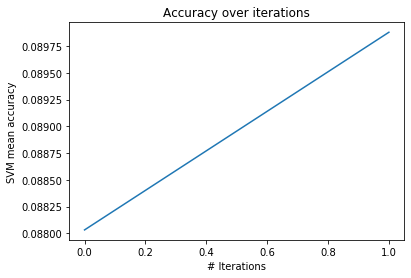

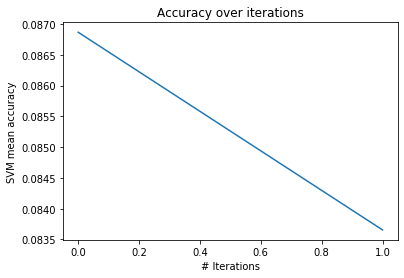

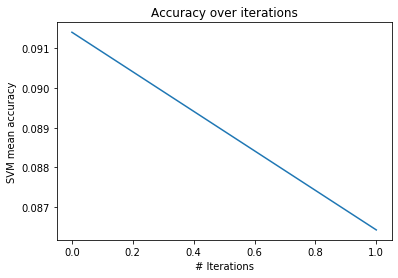

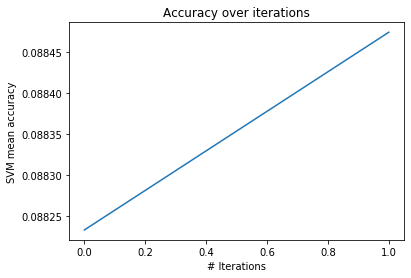

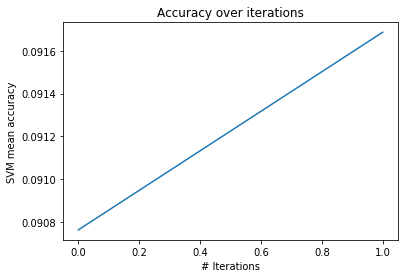

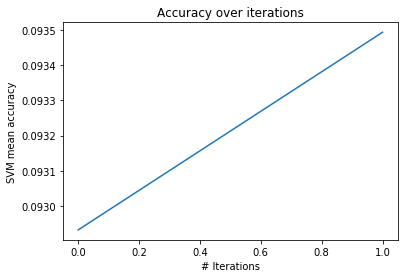

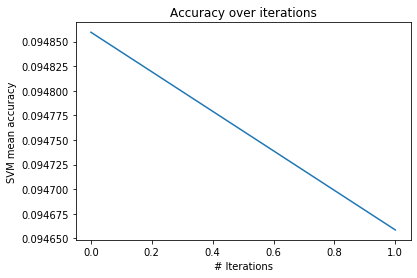

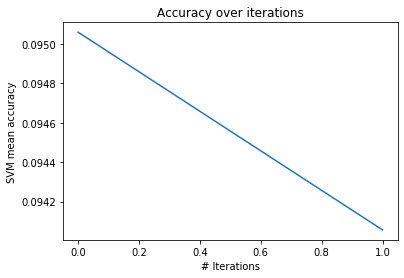

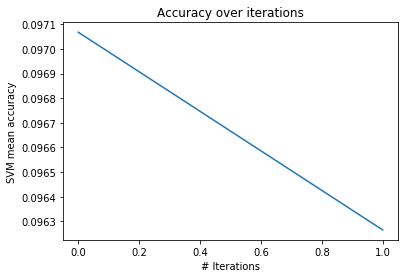

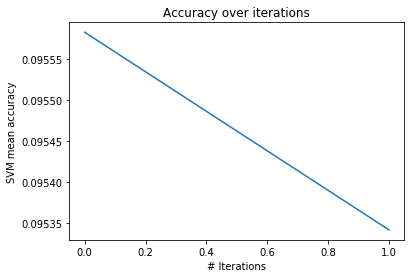

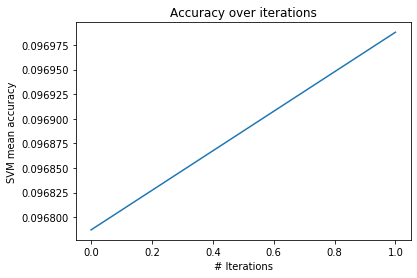

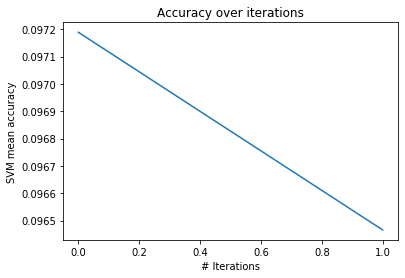

In [30]:
for id_, i in enumerate(mean_acc):
    plt.figure()
    plt.plot(i)
    plt.title('Accuracy over iterations')
    plt.xlabel('# Iterations')
    plt.ylabel('SVM mean accuracy')
    plt.show()

In [31]:
for i in pred:
    print(classification_report(labels_t, i, target_names = classes))

             precision    recall  f1-score   support

  aeroplane       0.00      0.00      0.00      2075
    bicycle       0.02      0.00      0.00      2075
        bus       0.00      0.00      0.00      2075
        car       0.11      0.07      0.08      2075
      horse       0.00      0.00      0.00      2075
      knife       0.17      0.00      0.00      2075
 motorcycle       0.00      0.00      0.00      2075
     person       0.00      0.00      0.00      2075
      plant       0.62      0.00      0.00      2075
 skateboard       0.00      0.00      0.00      2075
      train       0.21      0.11      0.14      2075
      truck       0.08      0.90      0.15      2075

avg / total       0.10      0.09      0.03     24900

             precision    recall  f1-score   support

  aeroplane       0.09      0.00      0.00      2075
    bicycle       0.06      0.11      0.08      2075
        bus       0.00      0.00      0.00      2075
        car       0.11      0.18      0.14

In [32]:
majority_vote = np.maximum.reduce([pred[0], pred[1], pred[2], pred[3], pred[4], pred[5], pred[6], pred[7], pred[8], pred[9], pred[10], pred[11]])

In [33]:
print(classification_report(labels_t, majority_vote, target_names = classes))

             precision    recall  f1-score   support

  aeroplane       0.00      0.00      0.00      2075
    bicycle       0.02      0.00      0.00      2075
        bus       0.00      0.00      0.00      2075
        car       0.12      0.06      0.08      2075
      horse       0.00      0.00      0.00      2075
      knife       0.16      0.00      0.00      2075
 motorcycle       0.29      0.00      0.01      2075
     person       0.20      0.00      0.00      2075
      plant       0.18      0.01      0.01      2075
 skateboard       0.22      0.00      0.00      2075
      train       0.20      0.09      0.13      2075
      truck       0.08      0.91      0.15      2075

avg / total       0.12      0.09      0.03     24900

